YEAR:  2007
        id   latitude  longitude    cp                  ville  \
0  1000001  4620114.0   519791.0  1000  SAINT-DENIS-LèS-BOURG   
1  1000001  4620114.0   519791.0  1000  SAINT-DENIS-LèS-BOURG   
2  1000001  4620114.0   519791.0  1000  SAINT-DENIS-LèS-BOURG   
3  1000001  4620114.0   519791.0  1000  SAINT-DENIS-LèS-BOURG   
4  1000001  4620114.0   519791.0  1000  SAINT-DENIS-LèS-BOURG   

           adresse     nom         maj  valeur  
0  ROUTE NATIONALE  Gazole  2007_01_04   999.0  
1  ROUTE NATIONALE  Gazole  2007_01_09   999.0  
2  ROUTE NATIONALE  Gazole  2007_01_12   989.0  
3  ROUTE NATIONALE  Gazole  2007_01_16   988.0  
4  ROUTE NATIONALE  Gazole  2007_01_17   988.0  
['Gazole' 'SP95' nan 'GPLc' 'E85']
val MAX Gazole [1999.0, 1964.0, 1900.0]
val MIN Gazole [1.0, 1.0, 1.0]
val MAX SP95 [1999.0, 1800.0, 1690.0]
val MIN SP95 [1.0, 1.0, 1.0]
val MAX GPLc [1312.0, 1280.0, 1199.0]
val MIN GPLc [507.0, 510.0, 510.0]
val MAX E85 [900.0, 899.0, 899.0]
val MIN E85 [750.0, 760

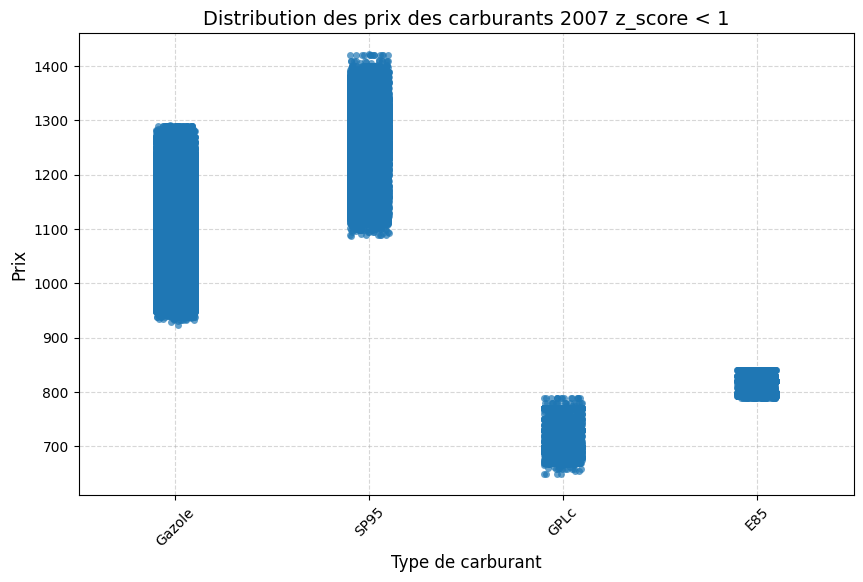

Save to CSV PrixCarburants_annuel_filtered_2007.csv


In [7]:
import pandas as pd
import os
from scipy.stats import zscore
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

pd.options.mode.chained_assignment = None
warnings.filterwarnings('ignore', category=RuntimeWarning)

for i in range(1): # one year only
    year = 2007
# for i in range (19): # all years
#     year = 2007+i
    print("YEAR: ", year)
    file_path = f"results/inputs_csv/PrixCarburants_annuel_{year}.csv"
    
    if not os.path.exists(file_path):
        print(f"Le fichier {file_path} n'existe pas.")
    else:
        df = pd.read_csv(file_path)
        print(df.head(5))

        df_prices = df.copy()
        df_prices["maj"] = pd.to_datetime(df_prices["maj"], format="%Y_%m_%d")
        
        # check min max value for each type carburant
        print(df_prices["nom"].unique())
        list_carburant = df_prices["nom"].dropna().unique()
        for carburant in list_carburant:
            df_carburant = df_prices[df_prices["nom"]== carburant]
            print(f"val MAX {carburant}", df_carburant.nlargest(3, 'valeur')['valeur'].tolist())
            print(f"val MIN {carburant}", df_carburant.nsmallest(3, 'valeur')['valeur'].tolist())

        # clean outlier data by Z-SCORE
        df_prices["z_score"] = df_prices.groupby(["maj", "nom"])["valeur"].transform(lambda x: zscore(x, ddof=0))
        df_prices_filtered = df_prices[abs(df_prices["z_score"]) < 1]

        # create median value for each station, each day and each carburant
        df_prices_filtered = df_prices_filtered.groupby(['id', 'maj', "nom"], as_index=False).agg({
            'latitude': 'first',
            'longitude': 'first',
            'cp': 'first',
            'ville': 'first',
            'adresse': 'first',
            'nom': 'first',
            'valeur': 'median'
        })
        ###### TO DO : GERER LES MEDIANS QUI FONT 1050.5
        print(df_prices_filtered.dtypes)
        
        plt.figure(figsize=(10, 6))
        sns.stripplot(data=df_prices_filtered, x="nom", y="valeur", jitter=True, alpha=0.7)   
        plt.title(f"Distribution des prix des carburants {year} z_score < 1", fontsize=14)
        plt.xlabel("Type de carburant", fontsize=12)
        plt.ylabel("Prix", fontsize=12)
        plt.xticks(rotation=45)
        plt.grid(True, linestyle="--", alpha=0.5)
        plt.show()

       
        
        ########### SAVE DF TO CSV ###################
        df_prices_filtered["maj"] = df_prices_filtered["maj"].dt.strftime("%Y_%m_%d")
        os.makedirs("results/inputs_csv_zscore_median", exist_ok=True)
        df_prices_filtered.to_csv(f"results/inputs_csv_zscore_median/PrixCarburants_annuel_filtered_{year}.csv", index=False)
        print(f"Save to CSV PrixCarburants_annuel_filtered_{year}.csv")